<a href="https://colab.research.google.com/github/RockNavamuel/stock_price_prediction/blob/main/Stock_Price_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import yfinance as yf
import pandas as pd

In [120]:
# Stock symbol (NASDAQ index)
stock= yf.Ticker("^IXIC")

In [121]:
stock = stock.history(period = "max")
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1971-02-05 00:00:00-05:00,100.000000,100.000000,100.000000,100.000000,0,0.0,0.0
1971-02-08 00:00:00-05:00,100.839996,100.839996,100.839996,100.839996,0,0.0,0.0
1971-02-09 00:00:00-05:00,100.760002,100.760002,100.760002,100.760002,0,0.0,0.0
1971-02-10 00:00:00-05:00,100.690002,100.690002,100.690002,100.690002,0,0.0,0.0
1971-02-11 00:00:00-05:00,101.449997,101.449997,101.449997,101.449997,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-24 00:00:00-04:00,14081.629883,14110.150391,13997.129883,14058.870117,4083070000,0.0,0.0
2023-07-25 00:00:00-04:00,14093.240234,14201.910156,14092.519531,14144.559570,3812470000,0.0,0.0
2023-07-26 00:00:00-04:00,14123.519531,14187.349609,14041.950195,14127.280273,4322000000,0.0,0.0


<Axes: xlabel='Date'>

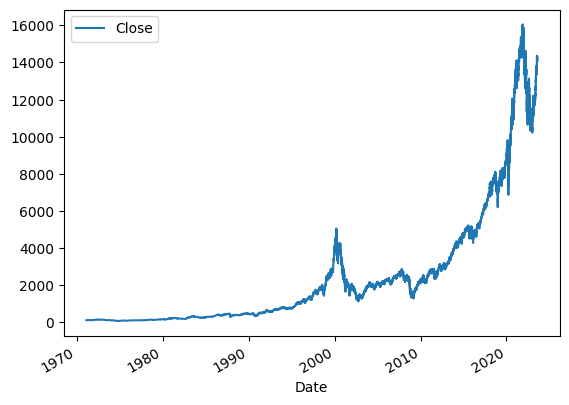

In [122]:
stock.plot.line(y = "Close", use_index = True)

In [123]:
# Create Tomorrow and Target columns for modeling
stock["Tomorrow"] = stock["Close"].shift(-1)
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)
stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target
Date,,,,,,,,,
1971-02-05 00:00:00-05:00,100.000000,100.000000,100.000000,100.000000,0,0.0,0.0,100.839996,1
1971-02-08 00:00:00-05:00,100.839996,100.839996,100.839996,100.839996,0,0.0,0.0,100.760002,0
1971-02-09 00:00:00-05:00,100.760002,100.760002,100.760002,100.760002,0,0.0,0.0,100.690002,0
1971-02-10 00:00:00-05:00,100.690002,100.690002,100.690002,100.690002,0,0.0,0.0,101.449997,1
1971-02-11 00:00:00-05:00,101.449997,101.449997,101.449997,101.449997,0,0.0,0.0,102.050003,1


In [124]:
# Aggregate more recent data
stock = stock.loc["1990-01-01":].copy()

In [104]:
# Construct model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [105]:
# When we predicted the price going up, did it actually go up?
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

precision_score(test["Target"], preds)

0.5

<Axes: xlabel='Date'>

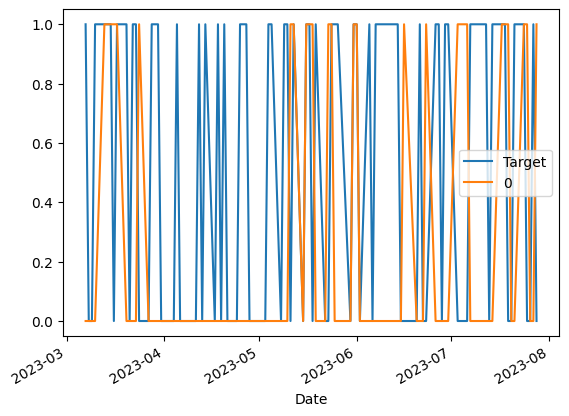

In [106]:
# Plot predictions
combined = pd.concat([test["Target"], preds], axis = 1)
combined.plot()

The model currently doesn't do a decent job predicting if the stock actually went up. The odds are as good as simply guessing.

In [107]:
# Backtesting

def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index = test.index, name = "Predictions")
  combined = pd.concat([test["Target"], preds], axis = 1)
  return combined

def backtest(data, model, predictors, start=2500, step = 250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [108]:
predictions = backtest(stock, model, predictors)

In [109]:
predictions["Predictions"].value_counts()

1    3343
0    2615
Name: Predictions, dtype: int64

In [110]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5381393957523183

In [111]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.541289
0    0.458711
Name: Target, dtype: float64

Currently our model performs slightly better with a precision score of 0.538 due to higher confidence in our model via the backtesting system.

In [112]:
# Add predictors
horizons = [2,5,60,250,1000] # measures for days elapsed

new_predictors = []

for horizon in horizons:
  rolling_avgs = stock.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  stock[ratio_column] = stock["Close"] / rolling_avgs["Close"]

  trend_column = f"Trend_{horizon}"
  stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

In [113]:
# We need ~4 years of info to receive complete data for new predictors
stock = stock.dropna()
stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,758.859985,760.179993,750.960022,751.469971,304880000,0.0,0.0,752.969971,1,0.994541,0.0,0.988436,0.0,0.981836,34.0,1.056673,152.0,1.362677,556.0
1993-12-15 00:00:00-05:00,751.260010,753.119995,750.299988,752.969971,287600000,0.0,0.0,755.530029,1,1.000997,1.0,0.994311,1.0,0.983380,35.0,1.058237,152.0,1.364674,556.0
1993-12-16 00:00:00-05:00,754.820007,756.340027,753.200012,755.530029,286970000,0.0,0.0,759.229980,1,1.001697,2.0,0.999265,2.0,0.986509,35.0,1.061280,152.0,1.368580,557.0
1993-12-17 00:00:00-05:00,758.710022,760.119995,757.169983,759.229980,310630000,0.0,0.0,760.150024,1,1.002443,2.0,1.004559,3.0,0.991190,35.0,1.065888,153.0,1.374532,558.0
1993-12-20 00:00:00-05:00,759.650024,760.580017,758.599976,760.150024,266180000,0.0,0.0,755.630005,0,1.000606,2.0,1.005662,4.0,0.992272,35.0,1.066597,153.0,1.375447,558.0


In [114]:
# New model
model = RandomForestClassifier(n_estimators = 200, min_samples_split=50, random_state =1)

def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1] # returns probability vs. value
  preds[preds >= 0.6] = 1
  preds[preds<= 0.6] = 0
  preds = pd.Series(preds, index = test.index, name = "Predictions")
  combined = pd.concat([test["Target"], preds], axis = 1)
  return combined

In [115]:
predictions = backtest(stock, model, new_predictors)

In [116]:
predictions["Predictions"].value_counts()

0.0    4118
1.0     839
Name: Predictions, dtype: int64

In [117]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5756853396901073

**Results**

The addition of new features, a backtesting system, and higher confidence of predicting (0.60 vs 0.50) achieved a precision score of 0.58. Meaning, our model currently predicts when a stock will be up at closing 58% of the time.
